In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup, get_polynomial_decay_schedule_with_warmup
from lion_pytorch import Lion
from torch.utils.data import DataLoader
import GLUEGPT2
from torch.optim.lr_scheduler import LambdaLR
from functools import partial
import numpy as np
from sklearn.metrics import matthews_corrcoef
import matplotlib.pyplot as plt
import datasets
from torch.utils.data import DataLoader
from transformers import GPT2Tokenizer
from transformers import GPT2LMHeadModel, GPT2Tokenizer



# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



Found cached dataset glue (/Users/xiongbowen/.cache/huggingface/datasets/glue/cola/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /Users/xiongbowen/.cache/huggingface/datasets/glue/cola/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-3bec0afcd36b72dc.arrow


Map:   0%|          | 0/1043 [00:00<?, ? examples/s]

Loading cached processed dataset at /Users/xiongbowen/.cache/huggingface/datasets/glue/cola/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-d55a8b5eb6b0e41a.arrow
Loading cached processed dataset at /Users/xiongbowen/.cache/huggingface/datasets/glue/cola/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-2257558fcd85bd6c.arrow


Map:   0%|          | 0/1043 [00:00<?, ? examples/s]

(array([237., 395., 198., 110.,  52.,  24.,  12.,   7.,   4.,   4.]),
 array([ 3. ,  6.1,  9.2, 12.3, 15.4, 18.5, 21.6, 24.7, 27.8, 30.9, 34. ]),
 <BarContainer object of 10 artists>)

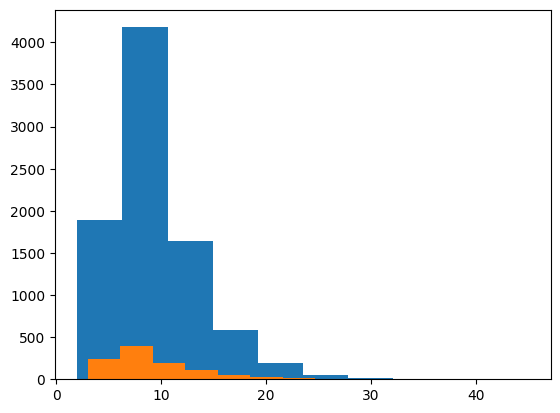

In [2]:
import torch.nn.utils.rnn as rnn_utils

train_dataset, test_dataset, _  = GLUEGPT2.get_torch_dataset('gpt2', "cola")

def pad_examples(batch):
    input_ids = rnn_utils.pad_sequence(batch['input_ids'], batch_first=True, padding_value=0)
    attention_mask = rnn_utils.pad_sequence(batch['attention_mask'], batch_first=True, padding_value=0)
    labels = batch['labels']
    return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': labels}

train_dataset = train_dataset.map(pad_examples, batched=True)
test_dataset = test_dataset.map(pad_examples, batched=True)


# length = torch.sum(train_dataset[:]["attention_mask"], dim=1).numpy()
attention_masks_sum = []
for i in range(len(train_dataset)):
    attention_mask = train_dataset[i]['attention_mask']
    attention_mask_sum = torch.sum(attention_mask).item()
    attention_masks_sum.append(attention_mask_sum)
plt.hist(attention_masks_sum)

attention_masks_sum_test = []
for i in range(len(test_dataset)):
    attention_mask = test_dataset[i]['attention_mask']
    attention_mask_sum = torch.sum(attention_mask).item()
    attention_masks_sum_test.append(attention_mask_sum)
# length = torch.sum(test_dataset[:]["attention_mask"], dim=1).numpy()
plt.hist(attention_masks_sum_test)

In [3]:

def constant_scheduler(
    optimizer, num_warmup_steps, num_training_steps, lr_end=1e-7, power=1.0, last_epoch=-1
):
    def lambda_func(step:int):
        return 1.

    return LambdaLR(optimizer, lambda_func, last_epoch)

In [4]:
def prepare(sche, opt):
    if sche == 'no':
        sches = partial(constant_scheduler)
    if sche == 'linear':
        sches = partial(get_linear_schedule_with_warmup)
    if sche == 'ord10':
        sches = partial(get_polynomial_decay_schedule_with_warmup,power = 10.0)

    if opt == 'Lion':
        opts = partial(Lion)
    if opt == 'Adam':
        opts = partial(torch.optim.Adam)
    if opt == 'AdamW':
        opts = partial(torch.optim.AdamW)


    return sches, opts


In [5]:
print(len(train_dataset),len(test_dataset))

8551 1043


In [6]:
lr_list = [1e-5,1e-4]
scheduler_list = ['no',  'ord10']
optimizer_list = ['Lion', 'AdamW']
batch_size_list = [32,64]
steps = 200

In [7]:
test_loader = DataLoader(test_dataset, shuffle = False, batch_size = 64)

In [8]:
next(iter(test_loader))

{'labels': tensor([1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
         1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0,
         1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1]),
 'input_ids': tensor([[  464, 29996, 22075,  ...,     0,     0,     0],
         [  464, 19590,   925,  ...,     0,     0,     0],
         [  464, 12370,  3654,  ...,     0,     0,     0],
         ...,
         [   40,  1101,  1654,  ...,     0,     0,     0],
         [49444,    88,  6619,  ...,     0,     0,     0],
         [30847,  6619,   546,  ...,     0,     0,     0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]])}

In [9]:
test_loader = DataLoader(test_dataset, shuffle = False, batch_size = 32)

In [10]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [11]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token  # Define the padding token

input_ids = tokenizer(['HA HA HA.','you are pig right?','You are bad.'], return_tensors='pt', padding=True)

model = GPT2LMHeadModel.from_pretrained('gpt2')

with torch.no_grad():
    logits = model(**input_ids).logits

predicted_class_id = logits.argmax().item()



In [12]:
# Training

loss_mat = np.zeros((len(batch_size_list),len(scheduler_list), len(optimizer_list), len(lr_list),steps))

report_step = 20 # evaluate test metric each step
metric_mat = np.zeros((len(batch_size_list),len(scheduler_list), len(optimizer_list), len(lr_list),steps//report_step))
for i,this_batch_size in enumerate(batch_size_list):
    for j,this_scheduler in enumerate(scheduler_list):
        for k,this_optimizer in enumerate(optimizer_list):
            for m, this_lr in enumerate(lr_list):

                model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)
                train_loader = DataLoader(train_dataset, batch_size=this_batch_size)
                sche, opt = prepare(this_scheduler, this_optimizer)
                optimizer = opt(model.parameters(), lr = this_lr)
                scheduler = sche(optimizer, num_warmup_steps=int(steps/10),num_training_steps=steps)
                step = 0
                print(f'Start training for: sche:{this_scheduler},opt:{this_optimizer},batchsize:{this_batch_size}, lr:{this_lr}')

                while True:
                    
                    for X in train_loader:
                        model.train()
                        optimizer.zero_grad()
                        batch = {k: v.to(device) for k, v in X.items()}
                        loss = model(**batch).loss
                        print(f"step: {step+1}, loss:{loss.item():.8f}")

                        loss_mat[i,j,k,m,step] = loss.item()

                        loss.backward()
                        optimizer.step()
                        scheduler.step()
                        step += 1

                    # valid
                        if (step)%report_step == 0:
                            model.eval()
                            with torch.no_grad():
                                logits = []
                                labelss = []
                                for X in test_loader:
                                    batch = {k: v.to(device) for k, v in X.items()}
                                    logits.append(model(**batch).logits)
                                    labelss.append(batch['labels'])
                                total_test = torch.concatenate(logits, dim = 0)
                                _,predicted = torch.max(total_test,dim = 1)
                                real_label =torch.concatenate(labelss,dim=0).cpu().numpy()
                                predicted = predicted.cpu().numpy()
                                metric = matthews_corrcoef(real_label, predicted)
                                acc = np.mean(predicted==real_label)
                                print(f"step:{step}, matthews_corr:{metric:.6f}, Acc:{acc*100:4f}%")

                        if step == steps:
                            break
                    if step == steps:
                      break

                del model
                del optimizer
                del scheduler
                del train_loader
                torch.cuda.empty_cache()



Start training for: sche:no,opt:Lion,batchsize:32, lr:1e-05


ValueError: Expected input batch_size (928) to match target batch_size (31).